In [ ]:
"""
⚠️ We are using a small sample (1000 rows) for GitHub demonstration.
Full dataset (70k+ rows) can be downloaded from:
"https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet"

Note: Train & validation metrics on this sample do not reflect real performance.
"""


In [229]:
# Data handling
import pandas as pd
import numpy as np
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Save/load model
import pickle


In [ ]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    # Convert to datetime
    df["lpep_dropoff_datetime"] = pd.to_datetime(df["lpep_dropoff_datetime"])
    df["lpep_pickup_datetime"] = pd.to_datetime(df["lpep_pickup_datetime"])

    # Trip duration in minutes
    df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).dt.total_seconds() / 60

    # Keep trips between 1 and 60 minutes
    df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]

    # Convert IDs to string
    df[["PULocationID", "DOLocationID"]] = df[["PULocationID", "DOLocationID"]].astype(str)

    # Keep only 1000 rows for GitHub
    df = df.sample(1000, random_state=42)

    return df


In [231]:
df_train = read_dataframe("/workspaces/mlops-end-to-end/data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("/workspaces/mlops-end-to-end/data/green_tripdata_2022-02.parquet")




Train shape: (73908, 21)
Validation shape: (59603, 21)


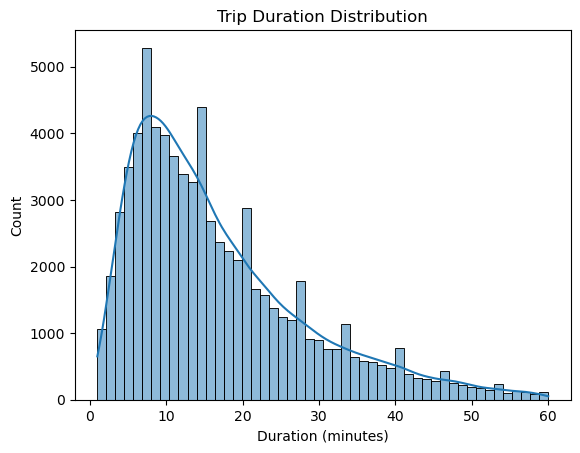

In [232]:
# Shape of datasets
print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)

# Trip duration distribution
sns.histplot(df_train['duration'], bins=50, kde=True)
plt.title("Trip Duration Distribution")
plt.xlabel("Duration (minutes)")
plt.show()


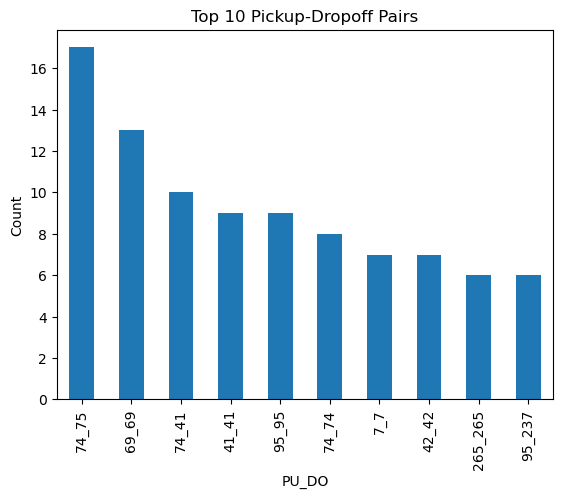

In [233]:
# Keep only trip_type = 2
df_train = df_train[df_train.trip_type == 2]
df_val = df_val[df_val.trip_type == 2]

# Create combined categorical feature
df_train["PU_DO"] = df_train['PULocationID'] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val['PULocationID'] + "_" + df_val["DOLocationID"]

# Visualize top PU_DO pairs
df_train['PU_DO'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Pickup-Dropoff Pairs")
plt.xlabel("PU_DO")
plt.ylabel("Count")
plt.show()


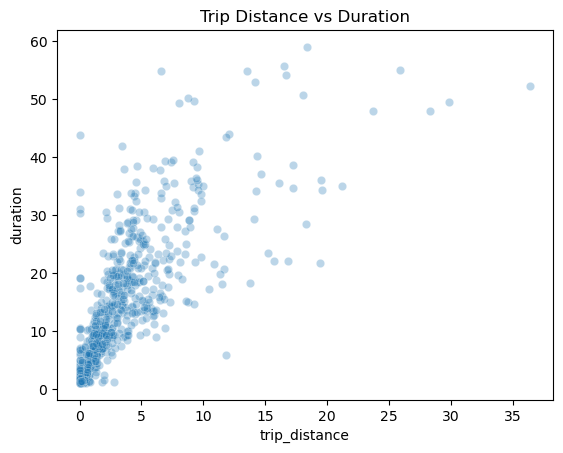

In [234]:
categorical = ["PU_DO"]
numerical = ["trip_distance"]
target = "duration"

y_train = df_train[target].values
y_val = df_val[target].values

# DictVectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(df_train[categorical + numerical].to_dict(orient='records'))
X_val = dv.transform(df_val[categorical + numerical].to_dict(orient='records'))

# Scatter plot trip_distance vs duration
sns.scatterplot(x='trip_distance', y='duration', data=df_train, alpha=0.3)
plt.title("Trip Distance vs Duration")
plt.show()


In [235]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr)


LinearRegression()


RMSE Train: 3.41
RMSE Validation: 8.25


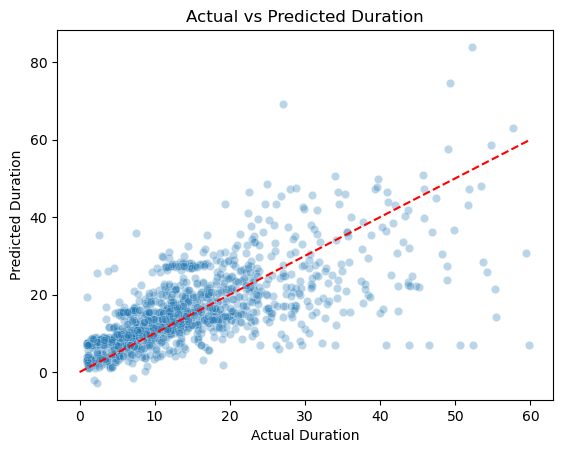

In [236]:
# Predictions
y_pred_train = lr.predict(X_train)
y_pred_val = lr.predict(X_val)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"RMSE Train: {rmse_train:.2f}")
print(f"RMSE Validation: {rmse_val:.2f}")

# Plot predicted vs actual
sns.scatterplot(x=y_val, y=y_pred_val, alpha=0.3)
plt.plot([0, 60], [0, 60], color='red', linestyle='--')  # perfect prediction line
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Actual vs Predicted Duration")
plt.show()


In [237]:
os.makedirs("models", exist_ok=True)
with open("models/linear_regression.pkl", "wb") as f_out:
    pickle.dump((dv, lr), f_out)


In [238]:
# Save sample datasets in the main data folder
df_train.to_parquet("../data/sample_train.parquet", index=False)
df_val.to_parquet("../data/sample_val.parquet", index=False)
